In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (12,8)
import dtutil.sqltools as sqltools

# Revenue Prediction Model

This page describes the revenue prediction methodology we are exploring for use when estimating revenue and
verifying that our quotas support the revenue prediction. I will first describe how we arrived at the 2018 revenue
estimate and then apply the same methodology to the 2017 revenue to show how it would have done in that year.

## 2018 Methodology

Because revenue contains GAAP artifacts that create noise in the revenue numbers, we have determined that annualized booking data will create better models.  There is some delta between revenue and AB data due to timing differences but overall they agree well.  We will break down annualized bookings as follows:

![breakdown of annualized bookings](ab_image.png)

Our revenue is composed of two distinct elements: 

* revenue from existing time-based deals and their renewals including the growth in these deals.
* revenue from new contracts which includes both new term deals and new perpetual sales.

In our prediction model we will predict these separately.

### Predicting time-based revenue (TB-RNW + TB-NR)

The data we use for this analysis is the core time-based AB which we define as our time-based AB with excess piracy removed and with adjustments made for currency.  The base data is:

In [36]:
import xlrd
df = pd.read_excel('file:///Users/dane/src/datatools/ipy/notebooks/adhoc/deliver/TBR_Clean.xlsx')
df = df.fillna(0)
by_year = df.groupby('Year').sum() / 1e6
by_year

,TimeBasedRevenue,ExcessPiracy,CurrencyAdjustment,Core
Year,,,,
2011,16.751113,0.000000,0.000000,16.751113
2012,19.750918,3.090326,0.000000,16.660592
2013,19.693586,2.181408,0.000000,17.512178
2014,20.444708,1.544459,-0.047267,18.947516
2015,19.929498,0.250030,-0.700065,20.379533
2016,20.603366,0.000000,-0.387796,20.991162
2017,22.062770,0.175000,-0.148695,22.036465


The first step is to do a regression fit on the core AB from 2013 to 2017

In [37]:
fit = np.polyfit(by_year.loc[2013:2017].index, by_year.loc[2013:2017].Core,1)
fit_fn = np.poly1d(fit)
print('Core = {:6.5f} * Year + {:5.1f}'.format(fit[0], fit[1]))

Core = 1.10922 * Year + -2215.1


We then use this to compute the core AB for 2018 which is:

In [38]:
core2018 = fit_fn(2018)
core2018

23.3010369673284

To the core AB we need to add Qualcomm which will be $650K for 2018.  We have determined that there is no anticipated currency adjustment for 2018 so the time-based revenue for 2018 is:

In [39]:
tbr2018 = core2018 + .650
by_year.loc[2018] = {'TimeBasedRevenue': tbr2018, 'ExcessPiracy': 0,
                     'CurrencyAdjustment': 0, 'Core': core2018}
by_year

,TimeBasedRevenue,ExcessPiracy,CurrencyAdjustment,Core
Year,,,,
2011,16.751113,0.000000,0.000000,16.751113
2012,19.750918,3.090326,0.000000,16.660592
2013,19.693586,2.181408,0.000000,17.512178
2014,20.444708,1.544459,-0.047267,18.947516
2015,19.929498,0.250030,-0.700065,20.379533
2016,20.603366,0.000000,-0.387796,20.991162
2017,22.062770,0.175000,-0.148695,22.036465
2018,23.951037,0.000000,0.000000,23.301037


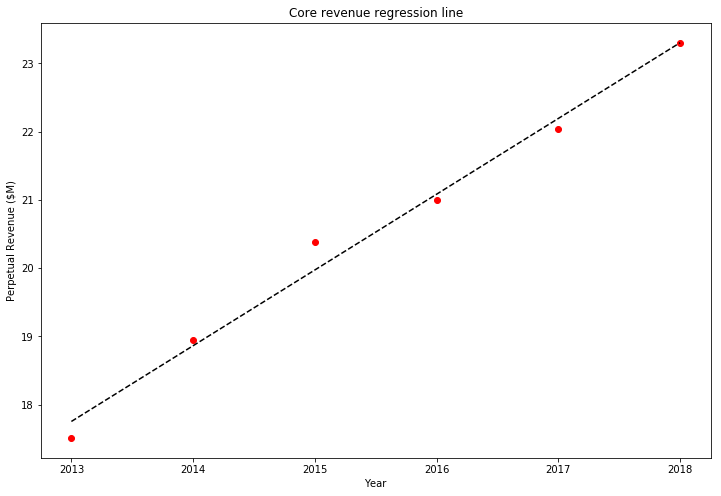

In [40]:
b = by_year.loc[2013:2018]
plt.plot(b.index, b.Core, 'ro', b.index, fit_fn(b.index), '--k');
plt.title('Core revenue regression line')
plt.xlabel('Year')
plt.ylabel('Perpetual Revenue ($M)');

### Predicting Non-Renewal Revenue (P-NRW + P-NR)

Next we need to predict the AB that comes from non-renewal deals. Because our methodology
for time-based AB includes revenue from new time-based deals (TB-NR), what we need to predict
here is just the perpetual portion of the non-renewal revenue.  This also include the perpetual
growth of the renewals (P-NRW).

Aside, why is P-NRW included with P-NR: P-NRW is the perpetual seats purchased by customers that
are renewing their existing maintenance contracts and adding seats. The problem we have is that if
a customer purchased a seat on a separate PO it will end up in P-NR but if it is on the maintenance
renewal PO it is P-RNW.  Because of this we feel that it is better to combine these into one bucket
for the model.

In the past we estimated the perpetual revenue by using a fraction of the overall revenue but
we have found this to not work well because perpetual revenue does not correlate well to total
revenue.

Our new approach takes the bookings for each territory.  From this it subtracts the renewals
in each territory to predict the non-renewal bookings in each territory. From annualized
bookings data we can compute the historical amount of non-renewal bookings in each territory
and compute the perpetual revenue produced by it. By averaging this over the past years we
predict a Perpetual to Non-Renewal Annualized Bookings ratio which we can apply to the 2018
quotas to produce an estimate of perpetual revenue.

Note there are some changes I make to the AB data including:

* I sum the AP-IND and EU-IND booking goal values and put them all in AP-IND where they have been historically
* I'm ignoring the EU-LAM territory because the values there are too sporatic to have a trend
* Piracy outside the EU-Piracy target are removed and not trended because they are too infrequent
* Catch-all territories like NA-Other and OTHER are excluded

In [41]:
def patch_ab_data(df):
    # move EU-IND data to AP-IND to match historical convention
    df.loc[2017, 'AP-IND'] += df.loc[2017, 'EU-IND']
    # then drop EU-IND
    df.drop('EU-IND', axis=1, inplace=True)
    # drop other useless columns and columns we're not going to try and extrapolate
    df.drop(['no_bg', 'Commission Exempt', 'OTHER', 'NA-Piracy', 'NA-Other', 'AP-Piracy', 'EU-LAM'], axis=1, inplace=True)
    # drop currency and type columns
    df.drop(['cur_mode', 'type'], axis=1, inplace=True)

Annualized Bookings has many different controls to change how the booking data is broken up. For this analysis, we
looked at all deals that were closed as won including piracy and universities but excluding ZTE. The perpetual part
is taken up front and the time-based part is spread out evenly per month with the months summed up to get results per year. This is as close to revenue as the AB analysis can get. Additional filters are then used to get smaller pieces.  
* The first filter only looks at non-renewal deals and all parts of each deal (perpetual and time-based).  
* The second filter is the same as the first filter (only non-renewals) and only the perpetual part.  
* The third filter is to look at the perpetual only on the renewal deals.   

These 4 groups were run with two different modes for converting currency.

* Mode 1 uses the same method as SFDC, where there are yearly rates set for currencies.
* Mode 2 uses monthly exchange rates and each monthly amount will use that month’s rate.

Here we're reading in the data for currency mode 1.

In [42]:
fn = 'file:///Users/dane/src/datatools/ipy/notebooks/adhoc/deliver/2018_quotas_data_dane.xlsx'
ab_data = pd.read_excel(fn, sheetname='model_input')
# filter for currency mode
ab_data_cm = ab_data[ab_data.cur_mode == 'CM1']
nr = ab_data_cm[ab_data_cm.type=='NR'].set_index('Year')
patch_ab_data(nr)
print('Total non-renewal AB (NR)')
nr.T

Total non-renewal AB (NR)


Year,2012,2013,2014,2015,2016,2017
AP-ANZ,235212,173825,65621,52832,69476,154399
AP-IND,191800,239304,208190,332864,777273,321577
AP-JPE-NT,417416,400095,233786,270799,327792,533854
AP-JPW-HT,303863,272188,418928,415274,419272,243674
AP-PRC,808728,731143,926764,774962,963357,473818
AP-ROA,30125,46701,77219,57640,28820,0
AP-ROK,807433,893754,877674,509502,884277,582283
AP-TSM,282114,381742,426970,265104,155125,166696
EU-DE,471517,238487,508939,853520,404144,358262
EU-FI,301211,184658,37702,243215,79058,207915


In [43]:
p_nr = ab_data_cm[ab_data_cm.type=='P_NR'].set_index('Year')
patch_ab_data(p_nr)
print('Perpetual non-renewal (P-NR)')
p_nr.T

Perpetual non-renewal (P-NR)


Year,2012,2013,2014,2015,2016,2017
AP-ANZ,69200,81600,31981,11760,9300,42624
AP-IND,157399,136781,121530,267814,649851,149839
AP-JPE-NT,192706,245621,110289,155521,234278,303175
AP-JPW-HT,175738,173906,313553,278677,222418,7830
AP-PRC,360933,291416,823256,470220,675312,288710
AP-ROA,12251,11537,31510,0,0,0
AP-ROK,692013,658414,652686,308225,579735,304917
AP-TSM,146393,305784,303997,148410,55328,79340
EU-DE,351046,120684,385080,663554,105540,143194
EU-FI,229216,146514,5274,191369,23976,116280


In [44]:
p_rnw = ab_data_cm[ab_data_cm.type=='P_RNW'].set_index('Year')
patch_ab_data(p_rnw)
print('Perpetual renewal (P-RNW)')
p_rnw.T

Perpetual renewal (P-RNW)


Year,2012,2013,2014,2015,2016,2017
AP-ANZ,0,0,0,0,16400,0
AP-IND,0,0,0,0,0,0
AP-JPE-NT,0,0,0,0,4740,0
AP-JPW-HT,0,0,0,0,6560,0
AP-PRC,0,0,0,0,0,0
AP-ROA,0,0,0,0,0,0
AP-ROK,0,0,14150,38000,105374,10000
AP-TSM,0,0,0,54625,0,7766
EU-DE,0,25364,0,0,11602,82775
EU-FI,15950,0,0,13837,510,0


We can compute the total perpetual revenue from adding P-RNW to P-NR

In [45]:
total_p = p_nr + p_rnw
total_p.T

Year,2012,2013,2014,2015,2016,2017
AP-ANZ,69200,81600,31981,11760,25700,42624
AP-IND,157399,136781,121530,267814,649851,149839
AP-JPE-NT,192706,245621,110289,155521,239018,303175
AP-JPW-HT,175738,173906,313553,278677,228978,7830
AP-PRC,360933,291416,823256,470220,675312,288710
AP-ROA,12251,11537,31510,0,0,0
AP-ROK,692013,658414,666836,346225,685109,314917
AP-TSM,146393,305784,303997,203035,55328,87106
EU-DE,351046,146048,385080,663554,117142,225969
EU-FI,245166,146514,5274,205206,24486,116280


From this we can compute the ratio of perpetual to non-renewal AB which is:

    (P-RNW + P-NR) / NR

In [46]:
p_nr_ratio = total_p / (nr + .00000000001)
p_nr_ratio.T

Year,2012,2013,2014,2015,2016,2017
AP-ANZ,0.294203,0.469438,0.487359,0.222592,0.369912,0.276064
AP-IND,0.820641,0.571578,0.583746,0.804575,0.836065,0.465951
AP-JPE-NT,0.461664,0.613907,0.471752,0.574304,0.729176,0.567899
AP-JPW-HT,0.578346,0.638919,0.748465,0.671068,0.546132,0.032133
AP-PRC,0.446297,0.398576,0.888312,0.606765,0.700999,0.609327
AP-ROA,0.406672,0.247040,0.408060,0.000000,0.000000,0.000000
AP-ROK,0.857053,0.736684,0.759776,0.679536,0.774767,0.540832
AP-TSM,0.518914,0.801023,0.711987,0.765869,0.356667,0.522544
EU-DE,0.744503,0.612394,0.756633,0.777432,0.289852,0.630737
EU-FI,0.813934,0.793434,0.139886,0.843723,0.309722,0.559267


The next step is to compute the average ratio over the years of interest. I use the 5-year period of 2013-2017 for this.

In [47]:
p_nr_avg = p_nr_ratio.loc[2013:2017].replace(0, np.nan).mean()  # have to replace the 0's for mean computation

As said previously, we do not want to compute a ratio for AP-Piracy, NA-Piracy and EU-LAM but since we have quotas for those we want to set their values to something reasonable.

In [48]:
p_nr_avg['NA-Piracy'] = p_nr_avg['EU-Piracy']
p_nr_avg['AP-Piracy'] = p_nr_avg['EU-Piracy']
p_nr_avg['EU-LAM'] = p_nr_avg['WW']
p_nr_avg

AP-ANZ       0.365073
AP-IND       0.652383
AP-JPE-NT    0.591407
AP-JPW-HT    0.527343
AP-PRC       0.640796
AP-ROA       0.327550
AP-ROK       0.698319
AP-TSM       0.631618
EU-DE        0.613410
EU-FI        0.529206
EU-FR        0.507330
EU-IL        0.650055
EU-Piracy    0.681239
EU-ROE       0.696237
EU-SC        0.370415
EU-UK        0.349748
NA-NE        0.493895
NA-SE        0.518252
NA-TX        0.309490
NA-WJS       0.444540
NA-WVJ       0.587112
WW           0.586208
NA-Piracy    0.681239
AP-Piracy    0.681239
EU-LAM       0.586208
dtype: float64

Next we need to load the quota for 2018.

In [49]:
fn = 'file:///Users/dane/src/datatools/ipy/notebooks/adhoc/deliver/rev_model_input.xlsx'
quota = pd.read_excel(fn, sheetname='2018 Quota', header=1).iloc[0:26,0:5]
quota = quota.set_index('Territory')
quota.drop(['NA-Maint', 'EU-LAM', 'AP-ASEAN'], inplace=True)  # these have no quota for new business
quota

,Quota,Renewals,Adjustments,Non-Renewal
Territory,,,,
AP-JPE-NT,1030000,724765,NaN,305235.0
AP-JPW-HT,1030000,569920,NaN,460080.0
AP-ROK,1280000,546438,NaN,733562.0
AP-ANZ,400000,290330,NaN,109670.0
AP-PRC,1390000,367316,175000.0,847684.0
AP-TSM,420000,175798,NaN,244202.0
AP-Piracy,200000,NaN,NaN,200000.0
AP-IND,400000,142650,NaN,257350.0
EU-FI,700000,653026,NaN,46974.0


Next let's add the ratio and compute the perpetual per territory

In [50]:
quota['ratio'] = p_nr_avg
quota['perpetual'] = quota['Non-Renewal'] * quota['ratio']
pd.set_option('display.float_format', '{:20,.2f}'.format)
quota

,Quota,Renewals,Adjustments,Non-Renewal,ratio,perpetual
Territory,,,,,,
AP-JPE-NT,1030000,724765,nan,"305,235.00",0.59,"180,518.26"
AP-JPW-HT,1030000,569920,nan,"460,080.00",0.53,"242,620.15"
AP-ROK,1280000,546438,nan,"733,562.00",0.70,"512,260.30"
AP-ANZ,400000,290330,nan,"109,670.00",0.37,"40,037.56"
AP-PRC,1390000,367316,"175,000.00","847,684.00",0.64,"543,192.36"
AP-TSM,420000,175798,nan,"244,202.00",0.63,"154,242.38"
AP-Piracy,200000,NaN,nan,"200,000.00",0.68,"136,247.75"
AP-IND,400000,142650,nan,"257,350.00",0.65,"167,890.75"
EU-FI,700000,653026,nan,"46,974.00",0.53,"24,858.95"


In [51]:
perpetual_2018 = quota[quota.index !='WW'].perpetual.sum()
print('Perpetual revenue estimate (by territory) for 2018 is   ${:,}'.format(int(perpetual_2018)))
print('Perpetual revenue estimate (using WW ratio) for 2018 is ${:,}'.format(int(quota.loc['WW','perpetual'])))

Perpetual revenue estimate (by territory) for 2018 is   $5,922,606
Perpetual revenue estimate (using WW ratio) for 2018 is $6,454,962


In [52]:
tmp_quota = quota.drop('WW')
tmp_quota['perpetual'].sum()

5922606.883435308

### Total Revenue

We can now add the two predictions to get the total revenue

In [53]:
total_revenue = perpetual_2018 / 1e6 + tbr2018 
"${:5.3f}M".format(total_revenue)

'$29.874M'

There are several adjustments we add in including $50K of D2T, currency and changes in italy. When those are added in we get

In [54]:
# add adjustments
d2t = .050
currency = .150
italy = .175
print("Adjusted revenue estimate is ${:5.3f}M".format(total_revenue + d2t + currency + italy))

Adjusted revenue estimate is $30.249M


## Applying Method to 2017

Now that we have developed the methodology, we want to see what we would have predicted if we had used it for 2017.

For this we will use the data from 2012-2016.

In [55]:
fit = np.polyfit(by_year.loc[2012:2016].index, by_year.loc[2012:2016].Core,1)
fit_fn = np.poly1d(fit)
print('Core = {:6.5f} * Year + {:5.1f}'.format(fit[0], fit[1]))

Core = 1.15285 * Year + -2302.9


Now we use this equation to compute the 2017 core revenue.

In [56]:
core2017 = fit_fn(2017)
core2017

22.356744821725442

For 2017 there was a $149K currency adjustment so we can now compute the full time-based revenue

In [57]:
adj2017 = .149
tbr2017 = core2017 + adj2017
tbr2017

22.505744821725443

Next we need the quotas and renewals for 2017.

In [58]:
fn = 'file:///Users/dane/Dropbox/Work/_WIP/18-revenue_model/variation_analysis_non_renewals.xlsx'
quota17 = pd.read_excel(fn, sheetname='2017 Quota', header=1).iloc[0:26,0:5]
quota17 = quota17.set_index('Territory')
quota17.drop(['NA-Maint', 'AP-ASEAN'], inplace=True)  # these have no quota for new business
quota17

,Quota,Renewals,Non-Renewal,Final
Territory,,,,
AP-JPE-NT,"1,300,000.00","765,987.00",534013,"1,508,122.00"
AP-JPW-HT,"1,400,000.00","747,754.00",652246,"1,248,054.00"
AP-ROK,"1,300,000.00","612,349.00",687651,"1,140,178.00"
AP-ANZ,"600,000.00","464,412.00",135588,"467,869.00"
AP-PRC,"1,250,000.00","722,230.00",527770,"1,512,945.00"
AP-TSM,"550,000.00","255,765.00",294235,"758,530.00"
AP-Piracy,"100,000.00",0.00,100000,nan
AP-IND,"600,000.00","331,696.00",268304,"533,955.00"
EU-FI,"400,000.00","350,783.00",49217,"300,551.00"


Next we will add the need to compute the territory ratio using 2012-2016 data.

In [59]:
pd.reset_option('display.float_format')

p_nr_avg17 = p_nr_ratio.loc[2012:2016].replace(0, np.nan).mean()  # have to replace the 0's for mean computation
p_nr_avg17['NA-Piracy'] = p_nr_avg17['EU-Piracy']
p_nr_avg17['AP-Piracy'] = p_nr_avg17['EU-Piracy']
p_nr_avg17['EU-LAM'] = p_nr_avg17['WW']
p_nr_avg17

AP-ANZ       0.368701
AP-IND       0.723321
AP-JPE-NT    0.570161
AP-JPW-HT    0.636586
AP-PRC       0.608190
AP-ROA       0.353924
AP-ROK       0.761563
AP-TSM       0.630892
EU-DE        0.636163
EU-FI        0.580140
EU-FR        0.560501
EU-IL        0.741487
EU-Piracy    0.702770
EU-ROE       0.737885
EU-SC        0.313641
EU-UK        0.319903
NA-NE        0.456110
NA-SE        0.538955
NA-TX        0.346560
NA-WJS       0.466736
NA-WVJ       0.615819
WW           0.607129
NA-Piracy    0.702770
AP-Piracy    0.702770
EU-LAM       0.607129
dtype: float64

In [60]:
quota17['ratio'] = p_nr_avg17
quota17['perpetual'] = quota17['Non-Renewal'] * quota17['ratio']
pd.set_option('display.float_format', '{:20,.0f}'.format)
quota17

,Quota,Renewals,Non-Renewal,Final,ratio,perpetual
Territory,,,,,,
AP-JPE-NT,"1,300,000","765,987",534013,"1,508,122",1,"304,473"
AP-JPW-HT,"1,400,000","747,754",652246,"1,248,054",1,"415,211"
AP-ROK,"1,300,000","612,349",687651,"1,140,178",1,"523,690"
AP-ANZ,"600,000","464,412",135588,"467,869",0,"49,991"
AP-PRC,"1,250,000","722,230",527770,"1,512,945",1,"320,984"
AP-TSM,"550,000","255,765",294235,"758,530",1,"185,631"
AP-Piracy,"100,000",0,100000,nan,1,"70,277"
AP-IND,"600,000","331,696",268304,"533,955",1,"194,070"
EU-FI,"400,000","350,783",49217,"300,551",1,"28,553"


**Note:** I do not have the renewal adjustments that were made when setting quota which causes territories like EU-ROE to have negative non-renewal values.

Now combine to get total revenue

In [61]:
perpetual_2017 = quota17[quota17.index !='WW'].perpetual.sum()
total_revenue17 = perpetual_2017 / 1e6 + tbr2017
print("Adjusted revenue estimate is ${:5.3f}M".format(total_revenue17))

Adjusted revenue estimate is $28.110M


### Comparing 2017 estimate to actual

Now that we have estimated 2017 how does it compare to the actual results.

In [62]:
print('The time-based revenue was $22.063M and ${:5.3f}M was predicted.'.format(tbr2017))
print('Perpetual revenue was ${:5.3f}M versus a predicted value of ${:5.3f}M'.format(
    total_p.loc[2017, 'WW'] / 1e6,
    perpetual_2017/1e6))
print('Total revenue was $27.150M and ${:5.3f}M was predicted'.format(total_revenue17))

The time-based revenue was $22.063M and $22.506M was predicted.
Perpetual revenue was $5.344M versus a predicted value of $5.604M
Total revenue was $27.150M and $28.110M was predicted


From this we see that for 2017 we would have over-predicted revenue by $1M with that split between over-estimating time-based revenue and the rest being in the perpetual prediction.

## Computing Error Bars

The standard deviations on the perpetual to non-renewal revenue are:

In [63]:
pd.reset_option('display.float_format')
p_nr_ratio.loc[2013:2017].replace(0, np.nan).std()

AP-ANZ       0.116289
AP-IND       0.160389
AP-JPE-NT    0.093071
AP-JPW-HT    0.286176
AP-PRC       0.177276
AP-ROA       0.113859
AP-ROK       0.095195
AP-TSM       0.187534
EU-DE        0.195197
EU-FI        0.303885
EU-FR        0.212234
EU-IL        0.350829
EU-Piracy    0.269145
EU-ROE       0.093292
EU-SC        0.286743
EU-UK        0.110247
NA-NE        0.118972
NA-SE        0.149019
NA-TX        0.077817
NA-WJS       0.073563
NA-WVJ       0.113795
WW           0.063798
dtype: float64

In small territories the variance is quite large and it seems to make more sense to use the world-wide standard deviation to compute the error bars.  We see the standard deviation is .063 on a nominal ratio of .607 which is 10% which on the perpetual revenue estimate of 5.6M is $560K.
